In [2]:
import pandas as pd
with pd.HDFStore("store.h5") as store:
    df = store['ddf']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0724 23:51:00.822678  5376 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0724 23:55:04.061984  5376 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [3]:
ddf = df.query('label != -1 & isEdited != 1 & (t_nah + t_nta + t_yta + t_esh) > 0 & (m_nah + m_nta + m_yta + m_esh) > 0')

In [64]:
ddf['label'].value_counts(sort=False)

2.0    13404
1.0    36988
0.0     8625
3.0     4195
Name: label, dtype: int64

In [189]:
#n = prior weight
#strongly averages out probabilities and prevents any absolute 1s or 0s in the output
#comparing n = 0 vs n = 1 with 1k samples and ground
#
#0.135213	0.590840	0.209759	0.064187
#0.149700	0.535442	0.224965	0.089894
#0.136446	0.585142	0.212048	0.066364
def norm_row(row,n=1):
    fields = ['nah','nta','yta','esh']
    for md in ['t','m']:
        sm = sum(map(lambda x: row[md + '_' + x] + n,fields))
        if sm > 0:
            for i, x in enumerate(fields):
                row[md + x] = (row[md + '_' + x] + n) / sm
    return row

#https://arxiv.org/pdf/1503.02531v1.pdf
#softmax distillation function - seems more biased at low temps
#temp = 1 vs temp = 10
#0.120741	0.582321	0.210538	0.047486
#0.185990	0.403319	0.271170	0.120300
import numpy as np
def distill_row(row,temp,n=1):
    fields = ['nah','nta','yta','esh']
    for md in ['t','m']:
        sm = sum(map(lambda x: row[md + '_' + x] + n,fields))
        if sm > 0:
            for x in fields:
                row[md + x] = (row[md + '_' + x] + n) / sm
                                     
        sm = sum(map(lambda x: np.exp((row[md + '_' + x] + n)/temp),fields))
        if sm > 0:
            for x in fields:
                row['s'+ md + x] = np.exp((row[md + '_' + x] + n)/temp) / sm
    return row

#softmax, even at higher temps tends to emphasize extremes

In [ ]:
#0.135213	0.590840	0.209759	0.064187
for f in ['nah','nta','yta','esh']:
    print(ddf.sample(1000).apply(distill_row,axis=1,args=[6,1])[['t'+f,'m'+f,'st'+f,'sm'+f]].describe())

In [ ]:
distill_row(ddf.loc['c77lbt'],80)

In [ ]:
ddf.sample(100).apply(distill_row,axis=1,args=[10,])[['tnah','tnta','tyta','tesh']].round(6)

In [194]:
ddf['length'] = ddf['selftext'].apply(len)

C:\Users\Jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [209]:
for l in ['locked','over_18','spoiler']:
    ddf[l] = ddf[l].apply(lambda x: 1 if x else 0)
#ddf['edited'] = ddf['edited'].apply(lambda x: 1 if x == x else 0)

C:\Users\Jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [211]:
sel = ddf.sample(1000).apply(norm_row,axis=1)[['edited','locked','over_18','length','upvote_ratio','num_comments','tnta','mnta','tyta','myta','tesh','mesh','tnah','mnah']]
sel.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,edited,locked,over_18,length,upvote_ratio,num_comments,tnta,mnta,tyta,myta,tesh,mesh,tnah,mnah
edited,1,0.00028,0.1,-0.021,0.013,0.11,-0.065,-0.049,0.12,0.11,0.0019,-0.012,-0.064,-0.059
locked,0.00028,1,-0.0052,0.054,0.017,0.33,-0.014,-0.013,0.054,0.063,-0.051,-0.064,-0.019,-0.021
over_18,0.1,-0.0052,1,0.035,0.014,0.0039,0.054,0.059,-0.037,-0.039,-0.014,-0.01,-0.027,-0.034
length,-0.021,0.054,0.035,1,0.12,0.00094,0.13,0.11,-0.12,-0.11,0.068,0.08,-0.089,-0.081
upvote_ratio,0.013,0.017,0.014,0.12,1,0.082,0.25,0.27,-0.29,-0.29,-0.045,-0.064,0.026,0.015
num_comments,0.11,0.33,0.0039,0.00094,0.082,1,0.092,0.13,-0.0067,-0.019,-0.078,-0.098,-0.092,-0.11
tnta,-0.065,-0.014,0.054,0.13,0.25,0.092,1,0.97,-0.73,-0.71,-0.3,-0.26,-0.43,-0.39
mnta,-0.049,-0.013,0.059,0.11,0.27,0.13,0.97,1,-0.7,-0.71,-0.31,-0.31,-0.41,-0.41
tyta,0.12,0.054,-0.037,-0.12,-0.29,-0.0067,-0.73,-0.7,1,0.98,-0.054,-0.072,-0.17,-0.18
myta,0.11,0.063,-0.039,-0.11,-0.29,-0.019,-0.71,-0.71,0.98,1,-0.051,-0.075,-0.18,-0.2


In [59]:
#x = ddf.sample(10000)
x = pd.concat([ddf[ddf['label'] == i].sample(min(ddf.label.value_counts())) for i in range(4)])
target = x['label']
data = x[['selftext','title']]
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(data, target, test_size=0.5, random_state=0)

Lesson: None of the variable other than upvote_ratio seem particularly correlated with judgement. Length also seems correlated. Not sure how helpful these soft target variables are either. Edits also seem to generally suggest YTA. Will try again with better correlation indicator

Max-based indicators tend to be slightly more influenced by metadata characteristics (upvote ratio, comments, etc)

In [169]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
   #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax


import numpy as np

def cat2bin(rows):
    return np.array([[int(row > 1), int(row % 2)] for row in rows])

test_bin = pd.DataFrame(cat2bin(ytest),ytest.index,columns=['OP','TO'])
print(pd.crosstab(test_bin['OP'],test_bin['TO']))
results['RNG'] = np.random.random_integers(0,3,len(ytest))
results = {}

TO     0     1
OP            
0   2044  2112
1   2083  2151


C:\Users\Jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer()
tfv.fit(list(xtrain.selftext) + list(xtrain.title) + list(xtest.selftext) + list(xtest.title))

xtrain_tfv = tfv.transform(xtrain.title) + tfv.transform(xtrain.selftext)
xtest_tfv = tfv.transform(xtest.title) + tfv.transform(xtest.selftext)

In [173]:
from sklearn.naive_bayes import MultinomialNB
nnb = MultinomialNB()
nnb.fit(xtrain_tfv,ytrain)
results["TF-IDF - MultinomialNB"] = nnb.predict(xtest_tfv)

NameError: name 'xgbc' is not defined

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBClassifier

#soft classifier
xgbc = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
xgbc.fit(xtrain_titles, ytrain)
results["USE - XGBClassifier"] = xgbc.predict(xtest_titles)

3.0    2598
0.0    2567
2.0    1627
1.0    1598
dtype: int64
              precision    recall  f1-score   support

           0       0.37      0.47      0.41      2044
           1       0.34      0.26      0.29      2112
           2       0.33      0.26      0.29      2083
           3       0.40      0.48      0.44      2151

   micro avg       0.37      0.37      0.37      8390
   macro avg       0.36      0.37      0.36      8390
weighted avg       0.36      0.37      0.36      8390



-------------- TF-IDF - MultinomialNB: 2991 2256 843 2300 ---------------
              precision    recall  f1-score   support

           0       0.38      0.56      0.45      2044
           1       0.34      0.36      0.35      2112
           2       0.34      0.14      0.20      2083
           3       0.43      0.46      0.44      2151

   micro avg       0.38      0.38      0.38      8390
   macro avg       0.37      0.38      0.36      8390
weighted avg       0.37      0.38      0.36      8390



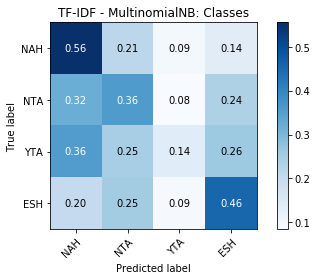

              precision    recall  f1-score   support

           0       0.64      0.47      0.54      4234
           1       0.61      0.65      0.63      4263

   micro avg       0.62      0.56      0.59      8497
   macro avg       0.62      0.56      0.59      8497
weighted avg       0.62      0.56      0.59      8497
 samples avg       0.39      0.41      0.38      8497

-------------- USE - XGBClassifier: 2567 1598 1627 2598 ---------------
              precision    recall  f1-score   support

           0       0.37      0.47      0.41      2044
           1       0.34      0.26      0.29      2112
           2       0.33      0.26      0.29      2083
           3       0.40      0.48      0.44      2151

   micro avg       0.37      0.37      0.37      8390
   macro avg       0.36      0.37      0.36      8390
weighted avg       0.36      0.37      0.36      8390



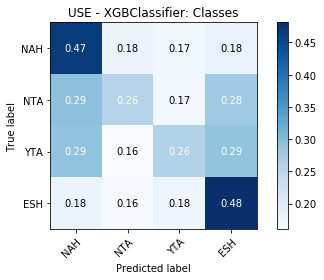

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      4234
           1       0.60      0.59      0.60      4263

   micro avg       0.60      0.60      0.60      8497
   macro avg       0.60      0.60      0.60      8497
weighted avg       0.60      0.60      0.60      8497
 samples avg       0.41      0.44      0.41      8497



In [187]:
import sklearn.metrics
#print(predictions)
#print(ytest.tolist())
for cls,pred in results.items():
    pred_bin = pd.DataFrame(cat2bin(pred),ytest.index,columns=['OP','TO'])
    x = pd.Series(pred).value_counts()
    print("-------------- " + cls + ": " + str(x[0]) + ' '+ str(x[1]) + ' '+ str(x[2]) + ' '+ str(x[3]) + ' ---------------')
    print(sklearn.metrics.classification_report(ytest.tolist(),pred,labels=[0,1,2,3]))
    plot_confusion_matrix(ytest.tolist(), pred, classes=['NAH','NTA','YTA','ESH'], normalize=True,
                      title= cls + ': Classes')
    print(sklearn.metrics.classification_report(test_bin,pred_bin))
    #print(plot_confusion_matrix(ytest.tolist(), predictions, classes=['NAH','NTA','YTA','ESH'], normalize=True,
    #                  title='Normalized confusion matrix'))

In [174]:
results["USE - XGBClassifier"] = hclf.predict(xtest_titles)